SARIMA MODEL:

In [1]:
# import yahoo finance data
import yfinance as yf
# import stockstats data
from stockstats import StockDataFrame as ss

# import necessary libraries
import matplotlib as mp
import numpy as np
import pandas as pd
import pytz
import warnings
import time
import random
import statistics
import pydoc
import os
import pyarrow
import pandas_gbq
import statsmodels
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

#import libraries for SARIMA model
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from datetime import date

2024-02-06 20:10:19.803232: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 20:10:20.631464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 20:10:20.631589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 20:10:20.813599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 20:10:21.180042: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 20:10:21.184961: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
apple_ticker = yf.Ticker("AAPL")
apple_data = yf.download("AAPL", start = '2020-01-01', interval = '1d')
apple_df = ss.retype(apple_data)

apple_data[['stochrsi', 'macd', 'mfi']] = apple_df[['stochrsi', 'macd', 'mfi']]
print(apple_data)
print(apple_ticker.get_capital_gains)

[*********************100%%**********************]  1 of 1 completed
                  open        high         low       close   adj close  \
Date                                                                     
2020-01-02   74.059998   75.150002   73.797501   75.087502   73.152672   
2020-01-03   74.287498   75.144997   74.125000   74.357498   72.441460   
2020-01-06   73.447502   74.989998   73.187500   74.949997   73.018684   
2020-01-07   74.959999   75.224998   74.370003   74.597504   72.675278   
2020-01-08   74.290001   76.110001   74.290001   75.797501   73.844345   
...                ...         ...         ...         ...         ...   
2024-01-30  190.940002  191.800003  187.470001  188.039993  188.039993   
2024-01-31  187.039993  187.100006  184.350006  184.399994  184.399994   
2024-02-01  183.990005  186.949997  183.820007  186.860001  186.860001   
2024-02-02  179.860001  187.330002  179.250000  185.850006  185.850006   
2024-02-05  188.149994  189.250000  185.839

In [3]:
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# import google cloud service account and bigquery
from google.oauth2 import service_account
from google.cloud import bigquery

# specify google cloud project information
credentials = service_account.Credentials.from_service_account_file(
    'black-vehicle-406619-bf2e31773163.json')
project_id = 'black-vehicle-406619'
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = 'stocks_ds'
table_id = '20yrs_stockdata'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
load_data = client.load_table_from_dataframe(apple_data, table_path, job_config=load_info)
load_data.result()

LoadJob<project=black-vehicle-406619, location=US, id=ca2a1299-10a8-4c3c-9394-2928aeaf52b3>

In [4]:
#Seasonal - fit stepwise auto-ARIMA
#!pip install pmdarima

# Remove any duplicate index
apple_data = apple_data.loc[~apple_data.index.duplicated(keep='first')]

#Filter only required data

apple_data = apple_data[['close']]

In [5]:
#Scale the APPL data into a standard range using MinMaxScaler ()

Feature_Scaler = MinMaxScaler()

#Transform current APPL data

apple_transformed = pd.DataFrame(np.squeeze(Feature_Scaler.fit_transform(apple_data), axis=1), columns=["Close"], index=apple_data.index)


In [6]:

sarima_model = pm.auto_arima(apple_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequency of the cycle (yearly)
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

# start_p=1, start_q=1: Sets the initial values for the order of the AR (AutoRegressive) and MA (Moving Average) components in the non-seasonal part of the model.
# test='adf': Specifies the use of the Augmented Dickey-Fuller (ADF) test to determine whether the time series is stationary and to help in determining the need for differencing (`d` parameter).
# max_p=3, max_q=3: Specifies the maximum values for the `p` and `q` parameters to consider during the model fitting process.
# start_P=0: Sets the initial value for the order of the seasonal AR component.
# d=None: The order of non-seasonal differencing is not specified, which allows the function to determine it automatically.
# trace=False: This means that the function will not print out diagnostic information about the steps it's taking.
# error_action='ignore': Instructs the function to ignore errors and try different combinations of parameters.
# suppress_warnings=True: Suppresses convergence warnings, which can be frequent in ARIMA modeling.
# stepwise=True: Enables a stepwise search to efficiently find the best model parameters.

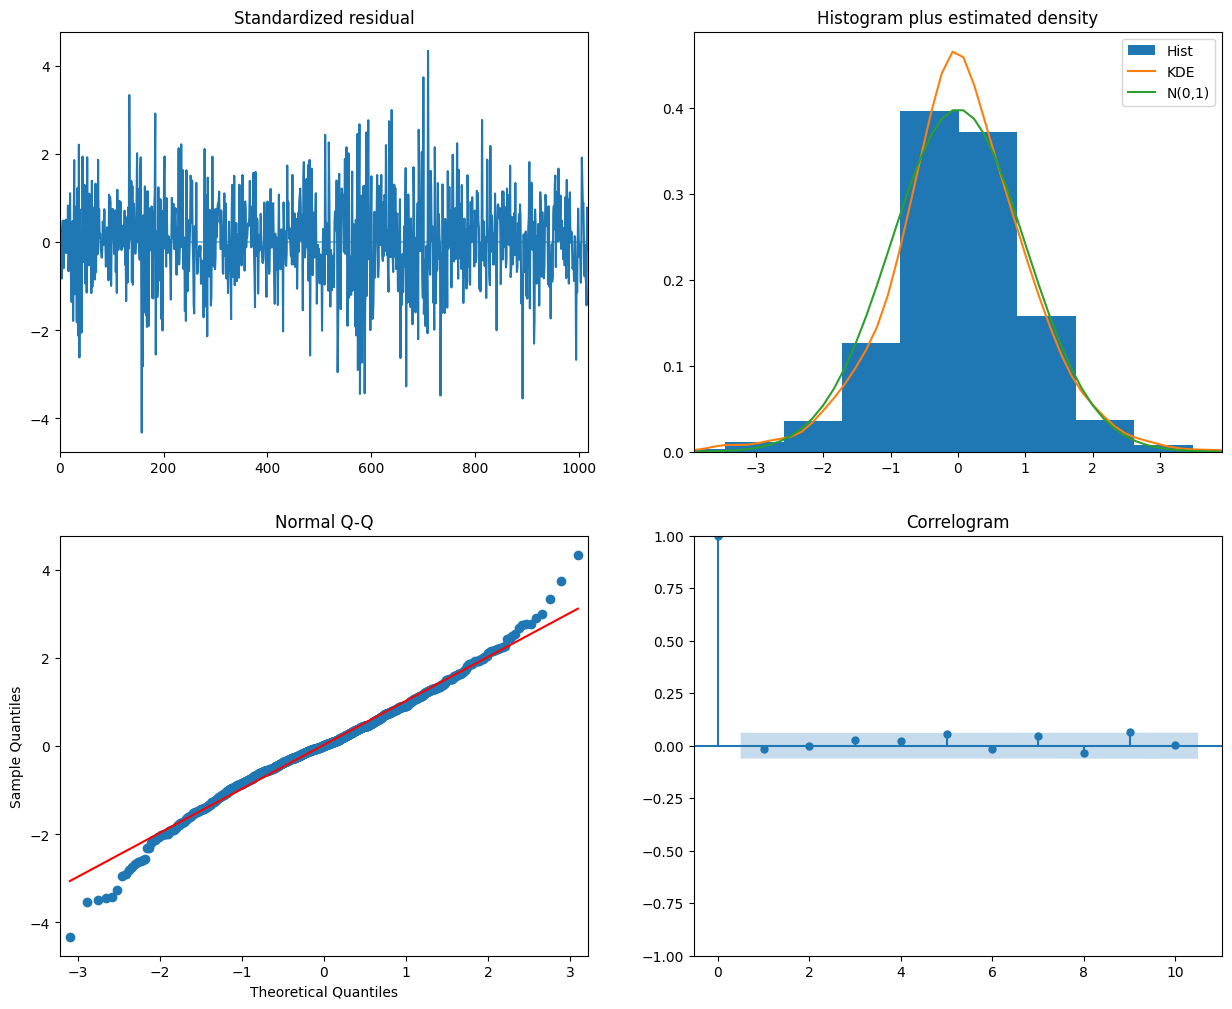

In [7]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [8]:
import pickle
# Serialize with Pickle and save it as pkl
with open('sarima_model.pkl', 'wb') as pkl:
    pickle.dump(sarima_model, pkl)

# Desiarilize the content of the file back into a Python object
with open('sarima_model.pkl', 'rb') as pkl:
    loaded_model = pickle.load(pkl)

In [9]:
def forecast(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

In [10]:
test=forecast(loaded_model, apple_transformed, '2024-03-01')

/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
test

,Actual,Prediction,Low,High
2020-01-02,75.087502,NaN,NaN,NaN
2020-01-03,74.357498,NaN,NaN,NaN
2020-01-06,74.949997,NaN,NaN,NaN
2020-01-07,74.597504,NaN,NaN,NaN
2020-01-08,75.797501,NaN,NaN,NaN
...,...,...,...,...
2024-02-26,NaN,183.290885,161.216849,205.364921
2024-02-27,NaN,183.436390,161.030521,205.842260
2024-02-28,NaN,182.727063,160.020076,205.434049
2024-02-29,NaN,186.203911,163.223280,209.184542


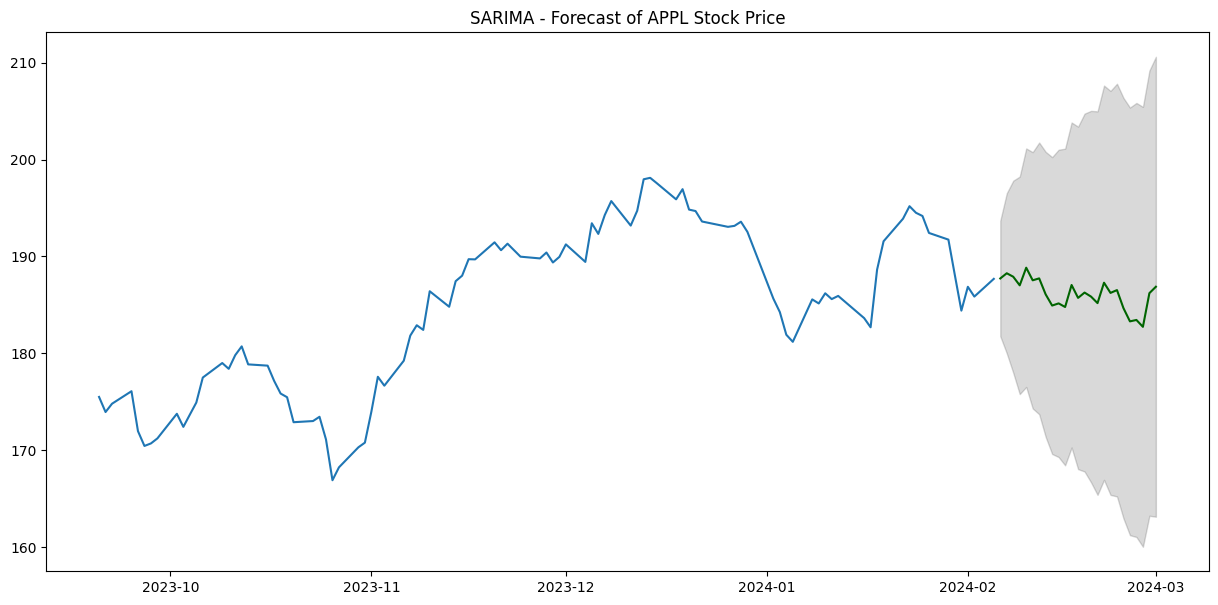

In [12]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(test["Actual"][-120:], color='#1f76b4')
plt.plot(test["Prediction"], color='darkgreen')
plt.fill_between(test.index,
                test["Low"],
                test["High"],
                color='k', alpha=.15)

plt.title("SARIMA - Forecast of APPL Stock Price")
plt.show()

LSTM MODEL:

In [13]:
apple_data = yf.download("AAPL", start = "2020-01-01", interval = '1d')
apple_df_test = apple_data.reset_index()
apple_df = apple_df_test.copy()

[*********************100%%**********************]  1 of 1 completed


In [14]:
scaler = MinMaxScaler()
data_transformed = pd.DataFrame(
    np.squeeze(
        scaler.fit_transform(
            apple_df[["Close"]])), columns=["Close"], index=apple_df.index)
#data_transformed["Date"] = (datetime)(apple_df["Date"])
#print(data_transformed)

In [15]:
def features_targets(data, feature_length):
    # feature length is the number of time steps in the input sequence
    # targets are the values the model is trying to forecast
    time_step_list, close_label_list = [], []
    
    # iterate through (length of sequential data) to (length of seq data - feature length)
    for i in range(len(data) - feature_length):
        # this will get the vals leading up to the target
        time_steps = data[i : i + feature_length]
        time_step_list.append(time_steps)
        # this will get the target val at this point
        labels = data[i + feature_length]
        close_label_list.append(labels)

    # reshape lists to be suitable for network algo
    time_step_list = np.array(time_step_list).reshape(len(time_step_list), feature_length, 1)
    close_label_list = np.array(close_label_list).reshape(len(close_label_list), 1)

    return time_step_list, close_label_list

In [16]:
time_step_vals, target_vals = features_targets(data_transformed["Close"].values, 20)

In [17]:
train_vals_cutoff = apple_df.loc[apple_df['Date'] >= '2022-01-01']
slice = train_vals_cutoff.shape[0]


In [18]:
def create_model(X, Y, df, data, train_test_slice, scaler):
    # training set: set to train the machine learning model
    # testing set: set used to test model after model has been trained
    # train set is 70% of data, test set is the rest (30%)
    X_train, X_test = X[:-train_test_slice], X[-train_test_slice:]
    Y_train, Y_test = Y[:-train_test_slice], Y[-train_test_slice:]

    # initialize empty model where nodes have input and output with Keras
    model = Sequential()
    # create a bidirectional LSTM: 
    # - 100 cells
    # - return output for input
    # - reduce overfitting w current dropout
    # - specify # of steps for target
    model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1, input_shape=(X_train.shape[1], 1))))
    # provide additional processing with undirectional layer
    model.add(LSTM(50, recurrent_dropout=0.1))
    # add dropout and dense layers
    # randomly sets 20% of inputs to 0 to prevent overfitting
    model.add(Dropout(0.2))
    # create a connected layer with 25 output units
    model.add(Dense(20, activation='elu'))
    model.add(Dropout(0.2))
    # create a connected layer with 10 output units
    model.add(Dense(10))
    # create a connected layer with 1 output unit
    model.add(Dense(1))

    # optimize model using stochastic gradient descent to train model
    # SGD 
    optimize = tf.keras.optimizers.SGD(learning_rate = 0.002)
    # compile model
    model.compile(loss='mean_squared_error', optimizer=optimize)
    # save model weights validation loss improves
    weights = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
    # adjust learning rate when needed
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=0.00001, verbose=1)

    # one epoch completes when the entire training dataset is processed once by the model
    model.fit(X_train, Y_train, epochs=12, batch_size=1, verbose=1, shuffle=False, validation_data=(X_test, Y_test), callbacks=[reduce_lr, weights])
    actual = scaler.inverse_transform(Y_test)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = np.squeeze(actual, axis=1)
    predictions = np.squeeze(predictions, axis=1)

    #reassign index before it goes into model
    test_df = pd.DataFrame({'Actual': actual, 'Predicted': predictions.flatten()})
    
    #print test_df plot
    '''
    # Plotting test set
    graph.plot(df.index[-train_test_slice:], predictions, label="Predicted")
    graph.plot(df.index[-train_test_slice:], actual, label="Actual")
    graph.xlabel('Date')
    graph.ylabel('Stock Price')
    graph.legend()
    graph.savefig('predicted_stock_prices_lstm3_test.png')
    graph.show()
    '''
    return model, X_train, X_test, Y_train, Y_test

In [19]:
# assign model, x training set, y training set, x testing set, and y testing set
lstm_model, X_train, X_test, Y_train, Y_test = create_model(
        time_step_vals, target_vals, apple_df, data_transformed["Close"].values, slice, scaler)

Epoch 1/12
485/485 [==============================] - 26s 45ms/step - loss: 0.0094 - val_loss: 0.0142 - lr: 0.0020
Epoch 2/12
485/485 [==============================] - 21s 43ms/step - loss: 0.0133 - val_loss: 0.0114 - lr: 0.0020
Epoch 3/12
485/485 [==============================] - 21s 43ms/step - loss: 0.0104 - val_loss: 0.0096 - lr: 0.0020
Epoch 4/12
485/485 [==============================] - 21s 43ms/step - loss: 0.0083 - val_loss: 0.0088 - lr: 0.0020
Epoch 5/12
485/485 [==============================] - 21s 44ms/step - loss: 0.0074 - val_loss: 0.0074 - lr: 0.0020
Epoch 6/12
485/485 [==============================] - 21s 44ms/step - loss: 0.0063 - val_loss: 0.0065 - lr: 0.0020
Epoch 7/12
485/485 [==============================] - 21s 44ms/step - loss: 0.0060 - val_loss: 0.0059 - lr: 0.0020
Epoch 8/12
485/485 [==============================] - 21s 43ms/step - loss: 0.0052 - val_loss: 0.0052 - lr: 0.0020
Epoch 9/12
485/485 [==============================] - 21s 44ms/step - loss: 0.00

In [20]:
# concatenate x sets, horiz axis
total_x = np.concatenate((X_train, X_test), axis = 0)
# concatenate y sets, horiz axis
total_y = np.concatenate((Y_train, Y_test), axis = 0)
# predict x axis with predict function
final_predict = lstm_model.predict(total_x)
# inverse transform x axis predictions
final_predict = scaler.inverse_transform(final_predict)
# inverse transform y predictions
actual = scaler.inverse_transform(total_y)
final_predict = np.squeeze(final_predict, axis = 1)
actual = np.squeeze(actual, axis = 1)

32/32 [==============================] - 0s 14ms/step


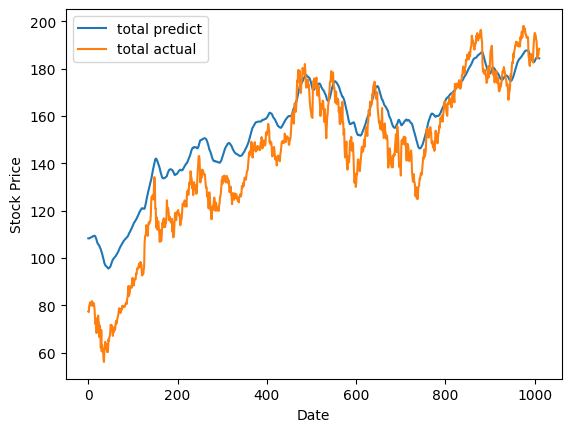

In [21]:
import matplotlib.pyplot as graph
graph.plot(final_predict, label = "total predict")
graph.plot(actual, label = "total actual")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.savefig('test.png')
graph.show()

In [22]:
def predict_lstm(model, df, future_date, scaler, feature_length=20):
    # iterate through today's date until future date
    for i in range((datetime.strptime(future_date, '%Y-%m-%d') - df.index[-1]).days):
        # specify close values
        feature_column = df['Close'].values
        # pick out last 20 days
        time_steps = feature_column[-feature_length:]
        # reshape array
        time_steps = time_steps.reshape(feature_length, 1)
        # scale array
        time_steps = scaler.transform(time_steps)
        prediction = model.predict(time_steps.reshape(1, feature_length, 1))
        prediction = scaler.inverse_transform(prediction)
        # concatenate results with og dataframe
        predicted_vals = pd.DataFrame(prediction, index=[df.index[-1] + timedelta(days=1)], columns=['Close'])
        df = pd.concat([df, predicted_vals])
    return df

In [23]:
print(lstm_model.summary())
lstm_model.predict(data_transformed[-21:-1].values.reshape(1,20,1))
data = pd.DataFrame(apple_data)
test_lstm = predict_lstm(lstm_model, data, '2024-03-01', scaler)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 20, 200)           81600     
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 50)                50200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                        

Total params: 133041 (519.69 KB)
Trainable params: 133041 (519.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 26ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step


In [24]:
# print close values leading up to march 1st
test_lstm.tail(30)

,Open,High,Low,Close,Adj Close,Volume
2024-01-30,190.940002,191.800003,187.470001,188.039993,188.039993,55859400.0
2024-01-31,187.039993,187.100006,184.350006,184.399994,184.399994,55467800.0
2024-02-01,183.990005,186.949997,183.820007,186.860001,186.860001,64885400.0
2024-02-02,179.860001,187.330002,179.250000,185.850006,185.850006,102518000.0
2024-02-05,188.149994,189.250000,185.839996,187.679993,187.679993,69668800.0
2024-02-06,186.860001,189.130005,186.769501,188.445694,188.445694,31134682.0
2024-02-07,NaN,NaN,NaN,184.356003,NaN,NaN
2024-02-08,NaN,NaN,NaN,184.098343,NaN,NaN
2024-02-09,NaN,NaN,NaN,183.825562,NaN,NaN
2024-02-10,NaN,NaN,NaN,183.550171,NaN,NaN


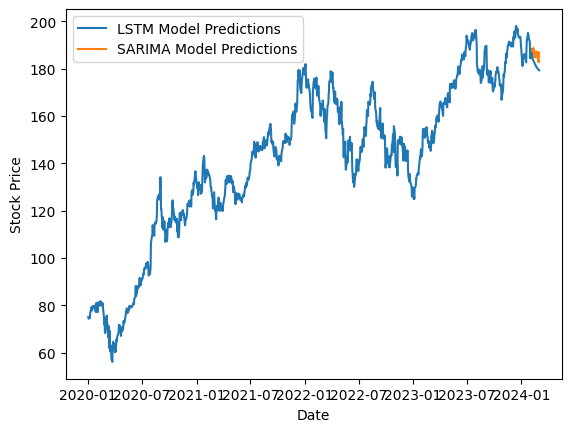

In [25]:
import matplotlib.pyplot as graph
graph.plot(test_lstm["Close"], label = "LSTM Model Predictions")
graph.plot(test["Prediction"], label = "SARIMA Model Predictions")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.savefig('test.png')
graph.show()

In [26]:
def forecasting(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    #Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

def combined_model(data_transformed, lstm_model, sarima_model, forecast_date, scaler):

  #print(data_transformed.tail())
  # create dataframes for high and low values
  df_high = pd.DataFrame(columns=['High'])
  df_low = pd.DataFrame(columns=['Low'])
  #last_initial_date = data_transformed.index[-1]
  # create variable referring to last day
  last_day = data_transformed.index[-1]
  #print(last_day)
  


  # iterate through the number of days between last day and future date
  for i in range((datetime.strptime(forecast_date, '%Y-%m-%d') - data_transformed.index[-1]).days):
    # call prediction function for lstm
    df_lstm_temp = predict_lstm(lstm_model, data_transformed, (data_transformed.index[-1] + timedelta(days=1)).strftime('%Y-%m-%d'), scaler)
    #print(df_lstm_temp.tail())
    # call forecast function for sarima
    df_sarima_temp = forecasting(sarima_model, data_transformed, (data_transformed.index[-1] + timedelta(days=i+1)).strftime('%Y-%m-%d'))
    #print(df_sarima_temp.tail())


    # combine 40% of lstm results and 60% of sarima results for closing vals on last day (day to predict)
    #combination = 0.4 * (scaler.transform(df_lstm_temp.iloc[-1]['Close'].reshape(1,-1))) + 0.6 * (scaler.transform(df_sarima_temp.iloc[-1]['Prediction'].reshape(1,-1)))
    combination = 0.3 * (scaler.transform(test_lstm.iloc[-1]['Close'].reshape(-1,1))) + 0.7 * (scaler.transform(df_sarima_temp.iloc[-1]['Prediction'].reshape(-1,1)))
    print(combination)

    # create new dataframe of combo :D
    forecast = pd.DataFrame(combination, index = [data_transformed.index[-1] + timedelta(days=1)], columns = ['Close'])
    data_transformed = pd.concat([data_transformed, forecast])
    # create new dataframe of low values
    df_low = pd.concat([df_low, pd.DataFrame(df_sarima_temp.iloc[-1]['Low'],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=['Low'])
    ])
    # create new dataframe of high values
    df_high = pd.concat([df_high, pd.DataFrame(df_sarima_temp.iloc[-1]['High'],
                                          index=[data_transformed.index[-1]+ timedelta(days=1)],
                                          columns=['High'])
    ])

  # squeeze final results to one axis, and inverse transform
  df_final = pd.DataFrame(np.squeeze(scaler.inverse_transform(data_transformed)),
                        index=data_transformed.index, columns=['Close'])

  #print(df_final.tail())

  # final actual df values are all days leading up to last day that has occurred
  df_final_actual = df_final[:last_day + timedelta(days=1)]
  # final predicted df values are all future days
  df_final_prediction = df_final[last_day + timedelta(days=1):]
  print(df_final_prediction.tail())

  return df_final_actual, df_final_prediction, df_low,  df_high



In [27]:
# get ~final~ combined results
combined_actual, combined_prediction, combined_df_low, combined_df_high = combined_model(apple_transformed, lstm_model, sarima_model, '2024-03-01', scaler)

1/1 [==============================] - 0s 30ms/step
[[0.90920959]]
1/1 [==============================] - 0s 29ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.91185553]]
1/1 [==============================] - 0s 29ms/step
[[0.9100855]]
1/1 [==============================] - 0s 28ms/step
[[0.90570408]]
1/1 [==============================] - 0s 32ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.91468829]]
1/1 [==============================] - 0s 28ms/step
[[0.9082699]]
1/1 [==============================] - 0s 30ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.90924526]]
1/1 [==============================] - 0s 28ms/step
[[0.90110983]]
1/1 [==============================] - 0s 29ms/step
[[0.89542086]]


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

1/1 [==============================] - 0s 32ms/step
[[0.8965217]]
1/1 [==============================] - 0s 28ms/step
[[0.89468228]]
1/1 [==============================] - 0s 32ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.90587854]]
1/1 [==============================] - 0s 29ms/step
[[0.89932232]]
1/1 [==============================] - 0s 27ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.90202675]]
1/1 [==============================] - 0s 30ms/step
[[0.89997217]]
1/1 [==============================] - 0s 31ms/step
[[0.89666174]]


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

1/1 [==============================] - 0s 33ms/step
[[0.90704791]]
1/1 [==============================] - 0s 32ms/step
[[0.90185739]]


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

1/1 [==============================] - 0s 31ms/step
[[0.90329009]]
1/1 [==============================] - 0s 32ms/step
[[0.89409987]]
1/1 [==============================] - 0s 26ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid 

[[0.88737257]]
1/1 [==============================] - 0s 29ms/step
[[0.88808976]]
1/1 [==============================] - 0s 31ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.8845935]]
1/1 [==============================] - 0s 31ms/step
[[0.90173078]]
1/1 [==============================] - 0s 29ms/step


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/wjulia800/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

[[0.90499002]]
                 Close
2024-02-26  182.114934
2024-02-27  182.216788
2024-02-28  181.720258
2024-02-29  184.154052
2024-03-01  184.616920


/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/wjulia800/.local/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [28]:
print(combined_actual.tail())

                 Close
2024-01-31  184.399994
2024-02-01  186.860001
2024-02-02  185.850006
2024-02-05  187.679993
2024-02-06  185.216174


In [29]:
print(combined_prediction.tail())

                 Close
2024-02-26  182.114934
2024-02-27  182.216788
2024-02-28  181.720258
2024-02-29  184.154052
2024-03-01  184.616920


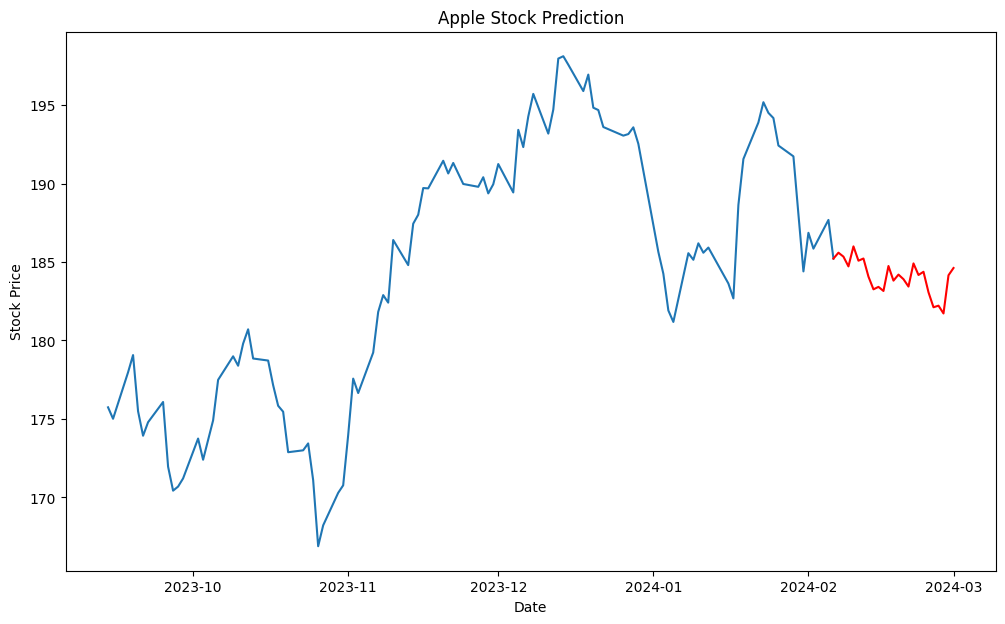

In [30]:

graph.figure(figsize=(12,7))
graph.plot(combined_actual.tail(100), color='#1f76b4')
graph.plot(combined_prediction, color='red')
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.title("Apple Stock Prediction")
graph.show()


In [31]:

# specify google cloud project information
dataset_id = 'predicted_prices'
table_id = 'SARIMA and LTSM Predicted Prices'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
# enter combined data load_data = client.load_table_from_dataframe(combined data, table_path, job_config=load_info)
load_data.result()

LoadJob<project=black-vehicle-406619, location=US, id=ca2a1299-10a8-4c3c-9394-2928aeaf52b3>